In [1]:
## Formulate/ Outline the problem
# The problem is to classify different classes of 
# images using a CNN

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from tensorflow import keras

import seaborn as sns
import pandas as pd

seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
## Identify inputs and outputs
# Inputs are images in the train and test np arrays
# Outputs are class labels

# download from internet
# import urllib.request 
# urllib.request.urlretrieve("https://zenodo.org/records/10970014/files/train_images.npy?download=1", "/content/train_images.npy")
# urllib.request.urlretrieve("https://zenodo.org/records/10970014/files/train_labels.npy?download=1", "/content/train_labels.npy")
# urllib.request.urlretrieve("https://zenodo.org/records/10970014/files/test_images.npy?download=1", "/content/test_images.npy")
# urllib.request.urlretrieve("https://zenodo.org/records/10970014/files/test_labels.npy?download=1", "/content/test_labels.npy")
# train_images = np.load('/content/train_images.npy')
# train_labels = np.load('/content/train_labels.npy')
# test_images = np.load('/content/test_images.npy')
# test_labels = np.load('/content/test_labels.npy')

# !wget https://zenodo.org/api/records/10970014/files-archive
# !unzip -j files-archive

train_images = np.load('./dollar_street_10/train_images.npy')
train_labels = np.load('./dollar_street_10/train_labels.npy')
test_images = np.load('./dollar_street_10/test_images.npy')
test_labels = np.load('./dollar_street_10/test_labels.npy')


In [3]:
# Normalize the values
train_images = train_images / 255.0
test_images = test_images / 255.0


In [7]:
# DenseNet121 prebuilt model - Transfer learning 
# input tensor
inputs = keras.Input(train_images.shape[1:])

# upscale layer
method = tf.image.ResizeMethod.BILINEAR
upscale = keras.layers.Lambda(
  lambda x: tf.image.resize_with_pad(x, 160, 160, method=method))(inputs)

base_model = keras.applications.DenseNet121(include_top=False,
                                            pooling='max',
                                            weights='imagenet',
                                            input_tensor=upscale,
                                            input_shape=(160,160,3),
                                            )

# Only train the top layers not the entire model
base_model.trainable = False

out = base_model.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(50, activation='relu')(out)
out = keras.layers.Dropout(0.5)(out)
out = keras.layers.Dense(10)(out)

model = keras.models.Model(inputs=inputs, outputs=out, name = 'tfl_model')
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 994ms/step - accuracy: 0.2642 - loss: 2.2619 - val_accuracy: 0.3447 - val_loss: 2.1067
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4260 - loss: 1.7075 - val_accuracy: 0.4437 - val_loss: 1.6930
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5399 - loss: 1.3379 - val_accuracy: 0.5017 - val_loss: 1.5353
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6253 - loss: 1.1477 - val_accuracy: 0.5700 - val_loss: 1.4354
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6629 - loss: 1.0155 - val_accuracy: 0.5768 - val_loss: 1.3786
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 998ms/step - accuracy: 0.7073 - loss: 0.9084 - val_accuracy: 0.5973 - val_loss: 1.3424
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 948ms/step - accuracy: 0.7403 - loss: 0.8216 - val_accuracy: 0.5904 - val_loss: 1.3143
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7836 - loss: 0.7059 - val_accuracy: 0.5939 - 

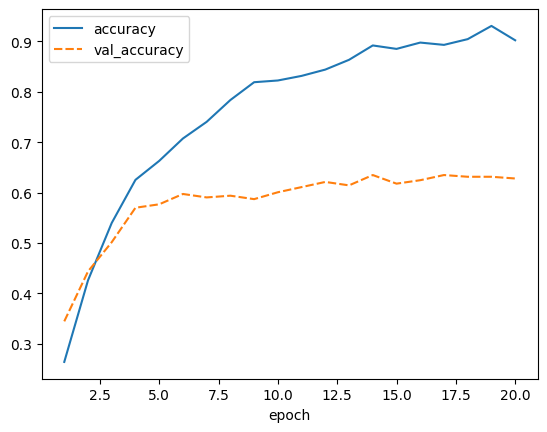

10/10 - 6s - 596ms/step - accuracy: 0.6280 - loss: 1.2983
Test acc: 62.79863715171814 %


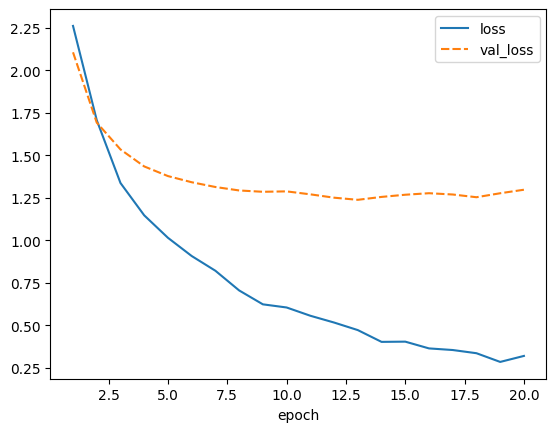

In [9]:
history_tfl = model.fit(train_images, train_labels, epochs=20,
                    validation_data=(test_images, test_labels))

history_df = pd.DataFrame.from_dict(history_tfl.history)
history_df['epoch'] = range(1,len(history_df)+1)
history_df = history_df.set_index('epoch')
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'Test acc: {test_acc * 100} %')
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.show()

In [ ]:
##Compare with ML
from sklearn import svm

train_images_ml = train_images.reshape(-1, (64*64*3))
print(train_images_ml.shape)
svc=svm.SVC()
svc.fit(train_images_ml, (train_labels))

(878, 12288)


SVC()

In [ ]:
from sklearn.metrics import accuracy_score
test_images_ml = test_images.reshape(-1, (64*64*3))
y_pred = svc.predict(test_images_ml)
print(accuracy_score(y_pred, test_labels))
#print(classification_report(y_pred, test_labels))

0.2525597269624573
